This notebooks evaluates the model resulting from the GridSearch in *Notebook 11*.

# Setup

## Basic Setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from tensorflow.keras.saving import register_keras_serializable

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import datetime
import random
import properscoring as ps

from scipy.stats import norm
from scikeras.wrappers import KerasRegressor

import xgboost
import pydot
import graphviz

from keras.models import load_model
from sklearn.multioutput import MultiOutputRegressor
import pickle

from sklearn.model_selection import ParameterGrid
from pathlib import Path
import joblib
import os

In [5]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [6]:
# Change Working Directory
os.chdir("..")
print(os.getcwd()) # print current working directory

c:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Probabilistic-Forecasting-of-Bicycle-Counts-in-Karlsruhe-with-Neural-Networks


In [7]:
plt.rcParams.update({'font.size': 14})

In [8]:
X_train = pd.read_pickle(r"data\X_train_final.pkl")
X_valid = pd.read_pickle(r"data\X_valid_final.pkl")
X_test = pd.read_pickle(r"data\X_test_final.pkl")

y_train = pd.read_pickle(r"data\y_train_final.pkl")
y_valid = pd.read_pickle(r"data\y_valid_final.pkl")
y_test = pd.read_pickle(r"data\y_test_final.pkl")


In [9]:
X_train.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,-0.039776,-0.397192,0,1,2,1.0,0.0,0.0,0.0,-0.218119,-0.031329,0
1,0.244625,-0.397192,0,1,3,1.0,0.0,0.0,0.0,-0.324284,-0.458165,0
2,0.381694,-0.371451,0,1,4,1.0,0.0,0.0,0.0,-1.076810,0.254435,0
3,1.300863,-0.397192,0,0,5,1.0,0.0,0.0,0.0,-0.405469,1.357699,0
4,0.745990,0.555250,0,0,6,1.0,0.0,0.0,0.0,0.297096,0.059103,0


In [10]:
X_valid.tail()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
359,-1.064496,-0.397192,0,1,1,0.0,0.0,0.0,1.0,-0.258711,-0.353265,1
360,-0.478837,-0.397192,0,1,2,0.0,0.0,0.0,1.0,1.087091,-0.823509,1
361,-0.104279,0.143383,0,1,3,0.0,0.0,0.0,1.0,2.276769,-0.913940,1
362,-0.691404,0.169125,0,1,4,0.0,0.0,0.0,1.0,-0.674006,-0.508807,1
363,0.541485,-0.397192,0,0,5,0.0,0.0,0.0,1.0,1.564836,-0.201340,1


In [11]:
y_test.head()

0    1160.0
1    2996.0
2    3635.0
3    3265.0
4    3751.0
Name: bike_count, dtype: float64

In [12]:
X_train.shape, X_valid.shape, X_test.shape

((3161, 12), (364, 12), (390, 12))

In [13]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [14]:
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [15]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [16]:
X_train.isna().sum()

temperature                 0
precipitation               0
public_holiday_indicator    0
is_workday                  0
day_of_week                 0
spring                      0
summer                      0
autumn                      0
winter                      0
windspeed                   0
sun                         0
school_holiday_indicator    0
dtype: int64

In [17]:
X_train.dtypes

temperature                 float64
precipitation               float64
public_holiday_indicator      int64
is_workday                    int64
day_of_week                   int64
spring                      float64
summer                      float64
autumn                      float64
winter                      float64
windspeed                   float64
sun                         float64
school_holiday_indicator      int64
dtype: object

In [18]:
X_train.describe()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
count,3.161000e+03,3.161000e+03,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3.161000e+03,3.161000e+03,3161.000000
mean,4.450726e-16,3.708939e-17,0.033534,0.684910,3.001898,0.243277,0.259412,0.259095,0.238216,4.832859e-17,4.720467e-17,0.232521
std,1.000158e+00,1.000158e+00,0.180054,0.464625,2.001106,0.429129,0.438381,0.438207,0.426059,1.000158e+00,1.000158e+00,0.422506
min,-2.660948e+00,-3.971923e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.513961e+00,-1.094803e+00,0.000000
25%,-7.932892e-01,-3.971923e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-7.364558e-01,-9.899026e-01,0.000000
50%,-9.270793e-04,-3.971923e-01,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-2.056287e-01,-2.085744e-01,0.000000
75%,7.907021e-01,-1.140338e-01,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,4.969366e-01,8.585175e-01,0.000000
max,2.566737e+00,1.461021e+01,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,4.952762e+00,2.193287e+00,1.000000


## Functions

In [19]:
def add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, col_name):
    
    X_train_num[col_name] = X_train[col_name]
    X_valid_num[col_name] = X_valid[col_name]
    X_test_num[col_name] = X_test[col_name]
    
    return X_train_num, X_valid_num, X_test_num

In [20]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [21]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [22]:
def predict_and_calculate_mean_crps(model, X_test = X_test, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    mean_crps = np.mean(ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std))
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std

In [23]:
def compile_and_fit_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [24]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [25]:
def process_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  X_test = X_test, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

In [26]:
X_test.tail()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
385,-1.826072,-0.397192,0,0,6,0.0,0.0,0.0,1.0,-1.030753,-0.403906,0
386,-0.641377,0.992859,0,1,0,0.0,0.0,0.0,1.0,2.053509,-1.094803,0
387,-0.525381,-0.268484,0,1,1,0.0,0.0,0.0,1.0,2.151868,-0.501572,0
388,-0.052053,0.091900,0,1,2,0.0,0.0,0.0,1.0,2.770125,-1.069482,0
389,-0.392344,-0.139775,0,1,3,0.0,0.0,0.0,1.0,-0.042477,-0.299006,0


# Hyperparameter Tuning

## Functions

In [27]:
@register_keras_serializable(package="Custom", name="crps_normal_cost_function")
def crps_normal_cost_function_v3(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    #print("y_true shape2: ", y_true.shape)
    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]
    
    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    
     # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))   
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps


In [28]:
@register_keras_serializable(package="Custom", name="crps_loss_function_wrapper")  
def crps_loss_function_wrapper(y_true, y_pred, tensor=True):
    """Wrapper for CRPS loss function.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """
    
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
       y_pred = tf.convert_to_tensor(y_pred.values)

    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = tf.convert_to_tensor(y_true.values, dtype=tf.float32)
        
    y_pred_reshaped = y_pred.reshape(-1, 2) #Keras Regressor flattens the values so they need to be reshaped

    crps = crps_normal_cost_function_v3(y_true, y_pred_reshaped, tensor)

    crps = crps.numpy()
    
    return crps

In [29]:
def tune_nn(input_shape_in, X_train_in, X_valid_in, X_test_in, y_train_in, y_valid_in, y_test_in, model_in=None, n_neurons=[64, 128, 256], dropout_rate=[0.1, 0.3, 0.5], 
            reg_values=[0.01], batch_size=[32], learning_rate=[1e-3, 1e-4], n_blocks=[1,2,4], epochs = 200, cv=5, n_jobs=1, verbose=10, patience=5):
    """Tune hyperparameters of a neural network using GridSearchCV.

    Args:
        input_shape_in: Number of features
        X_train_in: Training data
        X_valid_in: Validation data
        X_test_in: Test data
        y_train_in: Training targets
        y_valid_in: Validation targets
        y_test_in: Test targets
        model_in: Predefined model
        n_neurons: Number of neurons in hidden layers
        dropout_rate: Dropout rate
        reg_values: Regularization values
        batch_size: Batch size
        learning_rate: Learning rate
        n_blocks: Number of blocks
        epochs: Number of epochs
        cv: Number of cross-validation folds


    Returns:
        y_pred: Predictions on test data
        best_model: Best model
        cv_results: Results of cross-validation
    """


    iteration = 0

    # Define Keras model with hyperparameters
    def create_model(n_neurons, dropout_rate, reg_value, n_blocks):
        nonlocal iteration  # Declare iteration as nonlocal
        model = model_in
        input_shape = input_shape_in
        if model is None:
            model = Sequential()
            model.add(Input(shape=(input_shape,)))

            for i in range(n_blocks):
                model.add(Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(reg_value)))
                model.add(Dense(n_neurons, activation='relu'))
                model.add(Dropout(dropout_rate))
            
            # Output layer with two outputs: mean and std
            model.add(Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(reg_value)))
            model.add(Dense(2, activation='softplus'))
        
        if iteration % cv == 1 or iteration == 0: # don't print for every fold
            model.summary()
        
        iteration += 1
        # only to see that something is happening
        print("Iteration: " + str(iteration))

        
        model.compile(optimizer=tf.keras.optimizers.Adam(), loss=crps_normal_cost_function_v3 )
        return model

    # Define hyperparameters
    param_grid = dict(
       batch_size=batch_size,
       optimizer__learning_rate=learning_rate,
        model__n_neurons=n_neurons,
        model__dropout_rate=dropout_rate,
        model__reg_value=reg_values,
        model__n_blocks=n_blocks
    ) 


    # Create the model
    model = KerasRegressor(model=create_model, epochs=epochs, verbose=0)
    

    my_scorer = make_scorer(crps_loss_function_wrapper, greater_is_better=False) 

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=my_scorer)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    grid_search.fit(X_train_in, y_train_in, validation_data=(X_valid_in, y_valid_in), callbacks=[early_stopping])

    # Access the best hyperparameters and results
    best_params = grid_search.best_params_
    cv_results = pd.DataFrame(grid_search.cv_results_)
    best_model = grid_search.best_estimator_

    # Print the best hyperparameters
    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    y_pred = best_model.model_.predict(X_test_in)
    predicted_mean = y_pred[:, 0]
    predicted_std = y_pred[:, 1]

    mean_crps = np.mean(ps.crps_gaussian(y_test_in, mu=predicted_mean, sig=predicted_std))
    print(f"\nMean CRPS: { mean_crps }")
    
    return  y_pred, best_model, cv_results, grid_search
    

## Loading the GridSearchCV Results

In [30]:
# Define the base path using pathlib
base_path = Path(r"hyperparameter_tuning_results")

In [31]:
file_name_grid_search = "grid_search_tuned.pkl"
file_path_grid_search = base_path / file_name_grid_search

In [32]:
loaded_grid_search_tuned = joblib.load(str(file_path_grid_search))

In [33]:
loaded_grid_search_tuned.best_params_

{'batch_size': 32,
 'model__dropout_rate': 0.3,
 'model__n_blocks': 1,
 'model__n_neurons': 128,
 'model__reg_value': 0.01,
 'optimizer__learning_rate': 0.0001}

In [34]:
loaded_grid_search_tuned.best_index_

21

In [35]:
model = loaded_grid_search_tuned.best_estimator_

In [36]:
loaded_grid_search_tuned.best_score_

-393.70372517903644

In [37]:
mean_crps = predict_and_calculate_mean_crps(model.model_, X_test, y_test, print_predicted_mean_std = False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Mean CRPS: 324.37335963573844


In [38]:
loaded_grid_search_tuned.scorer_

make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict')

In [39]:
loaded_grid_search_tuned.n_splits_

3

In [40]:
loaded_grid_search_tuned.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KerasRegressor(epochs=200, model=<function tune_nn.<locals>.create_model at 0x0000028C5F14DDA0>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [32],
                         'model__dropout_rate': [0.1, 0.3, 0.5],
                         'model__n_blocks': [1, 2, 4],
                         'model__n_neurons': [64, 128, 256],
                         'model__reg_value': [0.01],
                         'optimizer__learning_rate': [0.001, 0.0001]},
             scoring=make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict'),
             verbose=10)>

In [41]:
loaded_grid_search_tuned.best_params_

{'batch_size': 32,
 'model__dropout_rate': 0.3,
 'model__n_blocks': 1,
 'model__n_neurons': 128,
 'model__reg_value': 0.01,
 'optimizer__learning_rate': 0.0001}

In [42]:
model.model_.summary()

Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1140 (Dense)              │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1141 (Dense)              │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_402 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1142 (Dense)              │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1143 (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,840 (409.54 KB)

 Trainable params: 34,946 (136.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 69,894 (273.03 KB)

In [43]:
cv_results_df = pd.DataFrame(loaded_grid_search_tuned.cv_results_)

In [44]:
cv_results_df['mean_test_score'] = -cv_results_df['mean_test_score']

## Plots

In [45]:
base_path_plots = Path(r"Figures\(12) GridSearch_Evaluation_Testing")

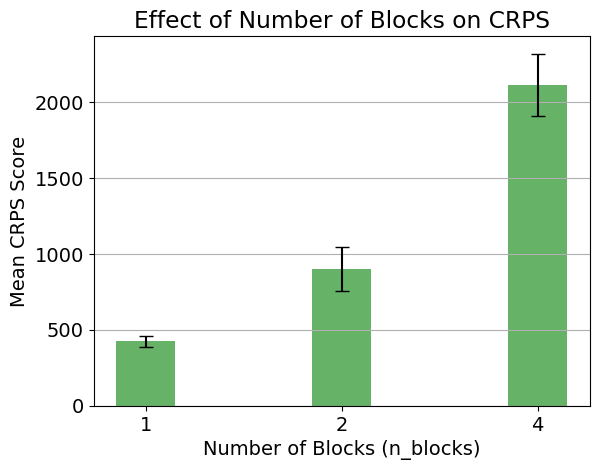

In [46]:
# Define the n_blocks and corresponding mean and std CRPS
n_blocks_values = cv_results_df['param_model__n_blocks'].unique()
mean_crps_n_blocks = [cv_results_df[cv_results_df['param_model__n_blocks'] == nb]['mean_test_score'].mean() for nb in n_blocks_values]
std_crps_n_blocks = [cv_results_df[cv_results_df['param_model__n_blocks'] == nb]['std_test_score'].mean() for nb in n_blocks_values]

# Adjust bar width and position
bar_width = 0.3  # Bar width
index = np.arange(len(n_blocks_values))  # Positions of bars on x-axis

# Bar chart for n_blocks with error bars (Non-overlapping bars)
plt.bar(index, mean_crps_n_blocks, yerr=std_crps_n_blocks, capsize=5, color='green', alpha=0.6, width=bar_width, label="n_blocks")

plt.title("Effect of Number of Blocks on CRPS")
plt.xlabel("Number of Blocks (n_blocks)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, n_blocks_values)  # Set the x-tick labels to be the n_blocks values
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "n_blocks_effect.png")
plt.show()

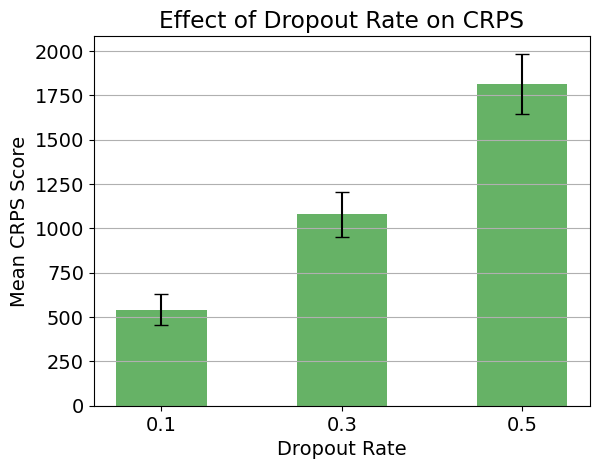

In [47]:
dropout_rates = cv_results_df['param_model__dropout_rate'].unique()
mean_crps_dropout = [cv_results_df[cv_results_df['param_model__dropout_rate'] == dr]['mean_test_score'].mean() for dr in dropout_rates]
std_crps_dropout = [cv_results_df[cv_results_df['param_model__dropout_rate'] == dr]['std_test_score'].mean() for dr in dropout_rates]

bar_width = 0.4 
index = np.arange(len(dropout_rates))  *0.8

plt.bar(index, mean_crps_dropout, yerr=std_crps_dropout, capsize=5, color='green', alpha=0.6, width=bar_width, label="Dropout Rate")

plt.title("Effect of Dropout Rate on CRPS")
plt.xlabel("Dropout Rate")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, dropout_rates)  
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "dropout_rate_effect.png")
plt.show()

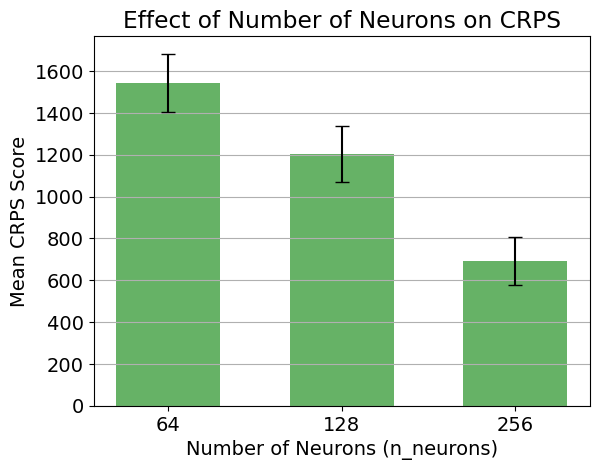

In [48]:
n_neurons_values = cv_results_df['param_model__n_neurons'].unique()
mean_crps_n_neurons = [cv_results_df[cv_results_df['param_model__n_neurons'] == nn]['mean_test_score'].mean() for nn in n_neurons_values]
std_crps_n_neurons = [cv_results_df[cv_results_df['param_model__n_neurons'] == nn]['std_test_score'].mean() for nn in n_neurons_values]


bar_width = 0.18 
index = np.arange(len(n_neurons_values)) *0.3

plt.bar(index, mean_crps_n_neurons, yerr=std_crps_n_neurons, capsize=5, color='green', alpha=0.6, width=bar_width, label="n_neurons")

plt.title("Effect of Number of Neurons on CRPS")
plt.xlabel("Number of Neurons (n_neurons)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, n_neurons_values) 
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "n_neurons_effect.png")
plt.show()


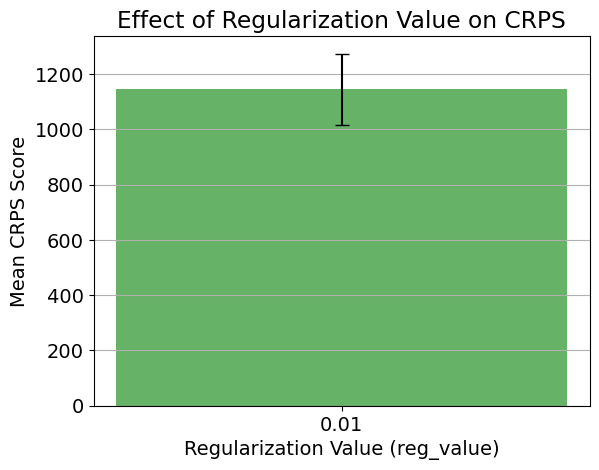

In [49]:
reg_value_values = cv_results_df['param_model__reg_value'].unique()
mean_crps_reg_value = [cv_results_df[cv_results_df['param_model__reg_value'] == rv]['mean_test_score'].mean() for rv in reg_value_values]
std_crps_reg_value = [cv_results_df[cv_results_df['param_model__reg_value'] == rv]['std_test_score'].mean() for rv in reg_value_values]

bar_width = 0.18
index = np.arange(len(reg_value_values))*0.3

plt.bar(index, mean_crps_reg_value, yerr=std_crps_reg_value, capsize=5, color='green', alpha=0.6, width=bar_width, label="reg_value")

plt.title("Effect of Regularization Value on CRPS")
plt.xlabel("Regularization Value (reg_value)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, reg_value_values)
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "reg_value_effect.png")
plt.show()


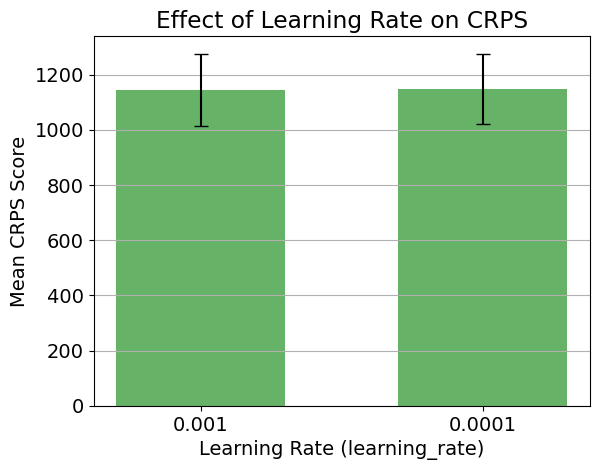

In [50]:
learning_rate_values = cv_results_df['param_optimizer__learning_rate'].unique()
mean_crps_learning_rate = [cv_results_df[cv_results_df['param_optimizer__learning_rate'] == lr]['mean_test_score'].mean() for lr in learning_rate_values]
std_crps_learning_rate = [cv_results_df[cv_results_df['param_optimizer__learning_rate'] == lr]['std_test_score'].mean() for lr in learning_rate_values]

bar_width = 0.18
index = np.arange(len(learning_rate_values)) * 0.3


plt.bar(index, mean_crps_learning_rate, yerr=std_crps_learning_rate, capsize=5, color='green', alpha=0.6, width=bar_width, label="learning_rate")
plt.title("Effect of Learning Rate on CRPS")
plt.xlabel("Learning Rate (learning_rate)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, learning_rate_values)
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "learning_rate_effect.png")
plt.show()

In [51]:
mean_crps_learning_rate

[1143.427641691985, 1148.1902827510128]

In [52]:
loaded_grid_search_tuned.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KerasRegressor(epochs=200, model=<function tune_nn.<locals>.create_model at 0x0000028C5F14DDA0>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [32],
                         'model__dropout_rate': [0.1, 0.3, 0.5],
                         'model__n_blocks': [1, 2, 4],
                         'model__n_neurons': [64, 128, 256],
                         'model__reg_value': [0.01],
                         'optimizer__learning_rate': [0.001, 0.0001]},
             scoring=make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict'),
             verbose=10)>